# Project Description

Beta Bank customers are leaving, ony by one, every month. Bankers discovered that it is cheaper to save existing customers than to attract new ones. `We need to predict whether a customer will leave the bank soon.` The data about the past behavior of clients and the termination of contracts with the bank will be provided.

## Objective
Create a model with the maximum possible F1 value to pass this test, the value should be at least 0.59. Additionally, I will measure the AUC-ROC metric to compare the F1 values

## Way to work
Along this project I focused on training and obtaining the best possible metrics for the models. You will find next the following structure:

- Preparing the data (Importing libraries and datasets).
- Preprocessing the data (Verifying duplicates, errors in datasets, null values, maintaining relevant information etc).
- Training a model (analyze the parameters to be improve and necessary process techniques).
- Rebalancing the datasets (oversampling)
- Training 3 classification models (Random Forest, SVM and Linear Regression)
- Conclusions




## Preparing the data

### Importing libraries

These are the libraries that will be used along the project.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importing Dataset

In [7]:
df = pd.read_csv('D:/Tripleten/datasets/Churn.csv')

### Preprocessing the data

In order to provide a complete analysis, first I need to ensure the imported dataset is prepared to be used for the model

In [8]:
## Quick view of the dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
## Analyzing dtypes and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [10]:
## Checking duplicated rows
df.duplicated().sum()

0

With the previous code I identified the following statements:
- name columns are OK
- dtypes are classified correctly 
- no duplicates found
- `Tenure has null values.`
- `"Geography" and "Gender" needs to be encoded into binary codes.`
- `Will be necessary to apply standard scaler`

Also, in my consideration; "RowNumber", "CustomerID" and "Surname" are not relevant for the model training, I'll proceed removing them and do the necessary changes.

#### Filtering by relevant columns

In [11]:
df.drop(columns=['RowNumber','CustomerId', 'Surname'], inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


#### Dropping null values

In [12]:
# Simple code to analyze the % of null values
((df['Tenure'].isna().sum())/df.shape[0] )*100

9.09

Now I will focus on the null values for Tenure, I'm considering two options:

- Eliminate the rows which represents 9.09% of the dataset (909 null values of the total 10000)
- Look for the median of the column Tenure and replace the null values.

I will proceed with the first option, avoiding to integrate fictitious data in our dataset. However the main objective is to predict the users who will leave the bank (value 1 of column 'Exited'), so, before removing the data I will analyze the impact of deleting the rows.

In [13]:
# Analyzing the shape of the df
print(f'Total Rows: {df.shape[0]}')

# Analyzing null rows for the Tenure column
print(f'Total Null Rows: {df['Tenure'].isnull().sum()}',  end='\n\n')

# Distribution of the exited values.
exited_null_rows = df['Exited'].value_counts()
print(f'Excited values distribution: \n{exited_null_rows}',end='\n\n')

# Distribution of the exited results for tenure null values. 
tenure_exited_null_rows = df[df['Tenure'].isnull()]['Exited'].value_counts()
print(f'Excited values distribution for null rows: \n{tenure_exited_null_rows}', end='\n\n')

print(f'The percentage of missing 1 values to be eliminated will be {((tenure_exited_null_rows[1]*100)/exited_null_rows[1]):.2f}%')


Total Rows: 10000
Total Null Rows: 909

Excited values distribution: 
Exited
0    7963
1    2037
Name: count, dtype: int64

Excited values distribution for null rows: 
Exited
0    726
1    183
Name: count, dtype: int64

The percentage of missing 1 values to be eliminated will be 8.98%


We have a total of 10000, from which 909 are null rows. Inside those 909 null rows we have 183 null tenure values. Considering the percentage of the values that will be eliminated we can proceed to delete it (does not represent high looses).

In [27]:
df.isna().sum() # To revalidate all null values came from Tenure column
df.dropna(inplace=True)
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Checking if the changes are correct

In [28]:
df.shape[0] # 9091 values
df.shape[0] + 909

10000

Transforming into 'integer' type.

In [29]:
df['Tenure']= df['Tenure'].astype(int)

Before jumping to remove any data, I will plot the data to see if something is missing.

In [30]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,0.704983,0.515565,100181.214924,0.203938
std,96.410471,10.555581,2.894723,62329.528576,0.581003,0.456076,0.499785,57624.755647,0.402946
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,51227.745000,0.000000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,1.000000,1.000000,100240.200000,0.000000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,1.000000,1.000000,149567.210000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


At first sight data seems right, means and medians are pretty similar for all the columns, standard deviation show a high variability for 'Balance' and 'Estimated Salary' columns. 

In the other hand a box plot chart could help to identify atypical values. 

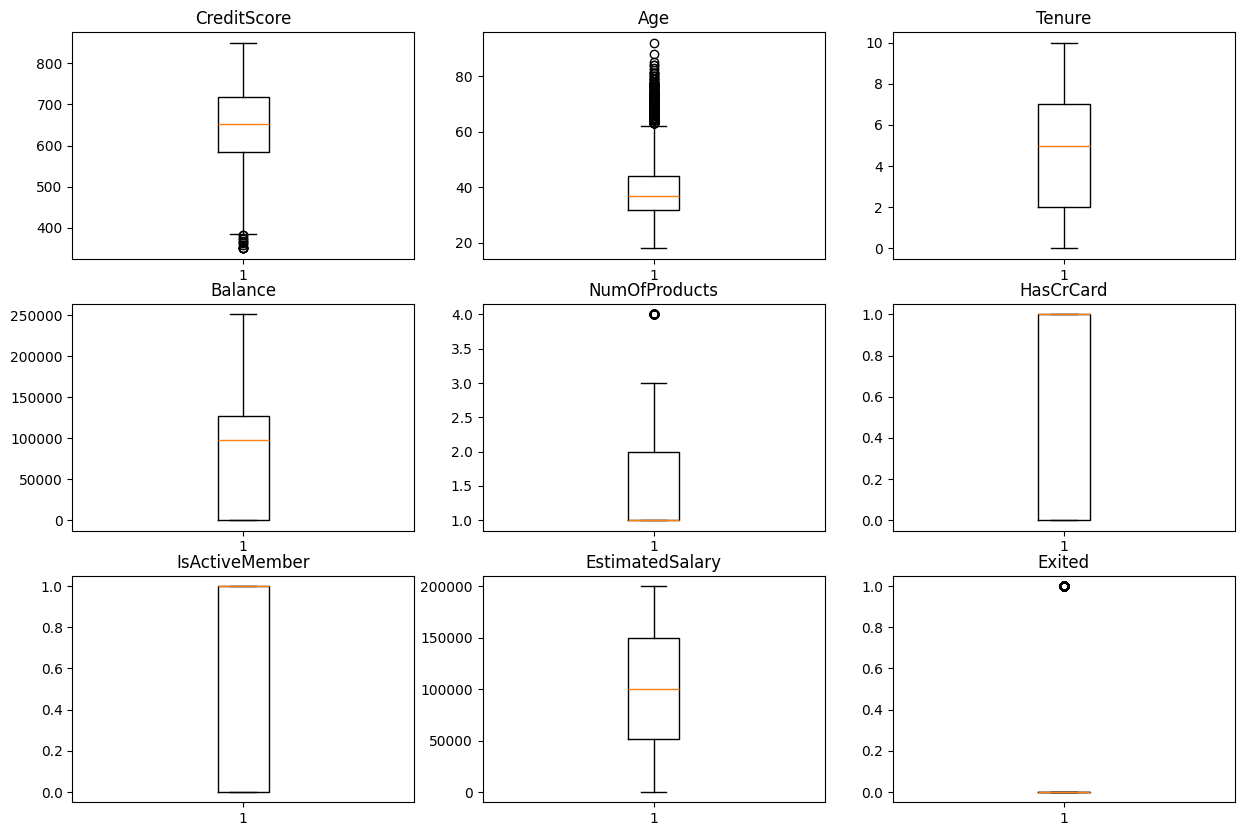

In [31]:
num_columns =df.select_dtypes(include=['int', 'float']).columns

# Creating a 3.3 figure that plots all the integer and float types.
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, column in enumerate(num_columns):
    row = i // 3
    col = i % 3    
    axs[row, col].boxplot(df[column])
    axs[row, col].set_title(column)
    i += 1

plt.show()


According to the previous charts we can infer the following:

Credit score: We have atypical values (outliers in the lower whisker), could be several situations like new clients with a credit history.

- Age: The analysis shows that the majority of the clients are concentrated between 20 - 60 years, however we can find users above this age.
- Tenure: Seems stable with a median of 5 and a max value of 10
- Balance: shows a highly concentration of the values located in the lower part, while some specific values represent high values
- Num of products: shows the value 1 as the median, however some clients can have up to 4 products.
- Has credit card and Is Active Member: Have a median of 1 having all their values in 0 or 1
- Estimated Salary: Have a normal distribution, not showing atypical values.
- Existe: Shows that the distribuition of clients remains with the banc, having atypical situation with users who left the banks


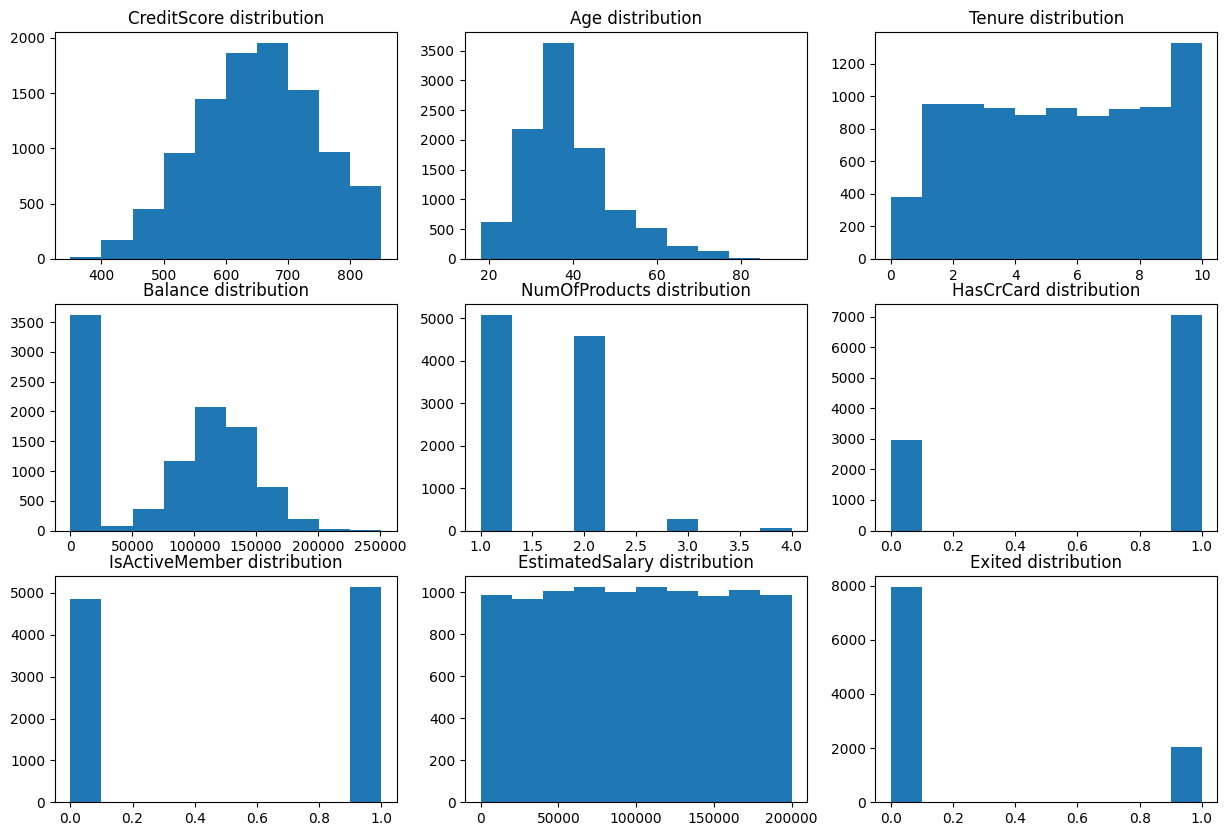

In [17]:
# Creating a figure that plot CreditScore and Age histograms
# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

num_columns =df.select_dtypes(include=['int', 'float']).columns

# Creating a 3.3 figure that plots all the integer and float types.
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i, column in enumerate(num_columns):
    row = i // 3
    col = i % 3    
    axs[row, col].hist(df[column])
    axs[row, col].set_title(f'{column} distribution')
    i += 1

plt.show()


This histogram graphs reinforce the highlights commented before.Let's also analize the categoric values.

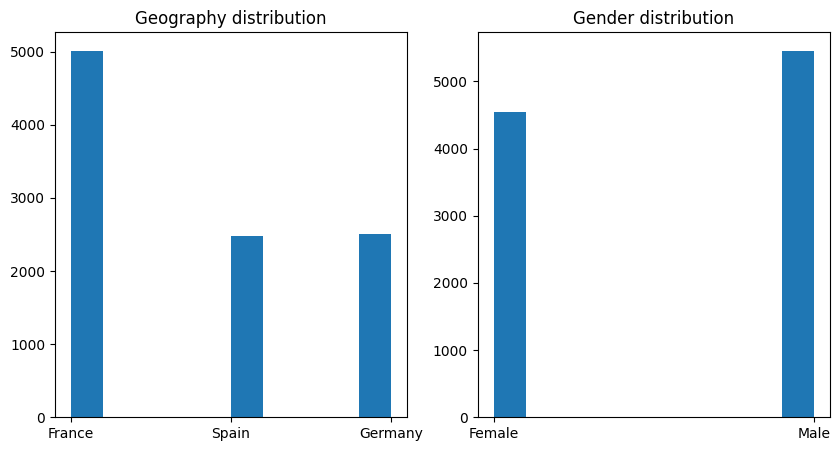

In [18]:
# Creating a figure that plot the object types
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(df['Geography'])
ax1.set_title('Geography distribution')
ax2.hist(df['Gender'])
ax2.set_title('Gender distribution')

plt.show()

As we can see the clients from france represents the half market of the product, while the distribution between males and females is similar. In the following charts we will filter the Geography and Gender analysis for users who left the bank.

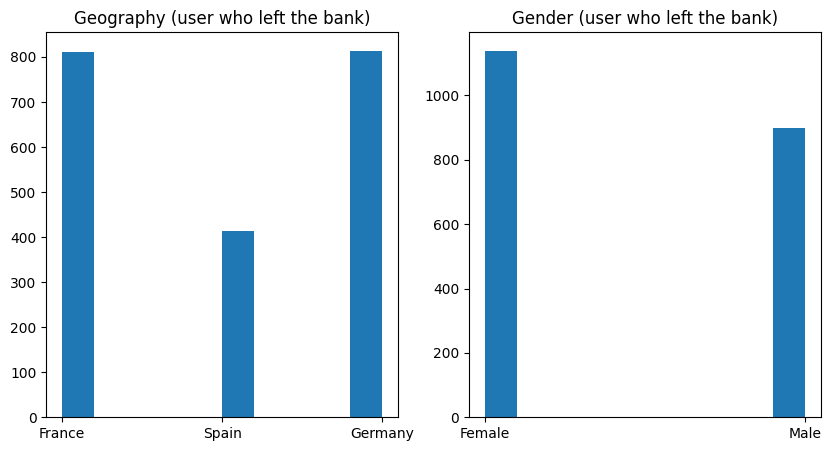

In [19]:
quit_users_df = df[df['Exited']==1]

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(quit_users_df['Geography'])
ax1.set_title('Geography (user who left the bank)')
ax2.hist(quit_users_df['Gender'])
ax2.set_title('Gender (user who left the bank)')

plt.show()

The results are interesting, Germany and France are the countries where users left the bank account.

In [35]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

#### One hot encoding

The dataset has been preproceed, let's focus on apply the OHE in our dataframe, remember get_dummies method will only affect the objects columns, transforming into binary bools

In [36]:
data_ohe = pd.get_dummies(data=df, dummy_na=False )
data_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,True,False,False,True,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,False,True,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,True,False,False,True,False
3,699,39,1,0.00,2,0,0,93826.63,0,True,False,False,True,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,29,2,0.00,2,0,0,167773.55,0,True,False,False,True,False
9995,771,39,5,0.00,2,1,0,96270.64,0,True,False,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,True,False,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,1,True,False,False,True,False


 Correlation map

In [38]:
correlation_with_exited = data_ohe.corr()['Exited'].sort_values(ascending=False)

print(correlation_with_exited)

Exited               1.000000
Age                  0.283017
Geography_Germany    0.178131
Balance              0.117218
Gender_Female        0.110450
EstimatedSalary      0.016029
HasCrCard           -0.005411
Tenure              -0.016761
CreditScore         -0.023950
NumOfProducts       -0.050271
Geography_Spain     -0.055971
Geography_France    -0.106426
Gender_Male         -0.110450
IsActiveMember      -0.155062
Name: Exited, dtype: float64


## Training a model

Now that our dataset is prepared, it will need to be split into two datasets to train to test our model. To do this, I'm setting `'X'` (features) and `'y'` (objective) to use it as parameters for the method train_test_split

In [ ]:
X = data_ohe.drop(columns='Exited')
y = data_ohe['Exited']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1000)

Now, I will use the class `GridSearchCV` which will allow to grid my search when training my model 

In [ ]:
params = {
'n_estimators': np.arange(1,101,10),
'max_depth': np.arange(1,6,1) ,
}

scoring = {'accuracy': 'accuracy', 
           'recall': 'recall',
           'f1': 'f1'}

rfc_gr = GridSearchCV(RandomForestClassifier(random_state=1000), param_grid=params, cv=3, verbose=2 ,scoring =scoring, refit='f1')
rfc_gr.fit(X_train,y_train)

It was necessary to eliminate the `precision ` parameter in the previous training model because it was sending a warning explaining that the model could not predict the class due to an imbalance. In other words it is necessary `to assign weight to the class 1 for the parameter 'class_weight'`, or `apply class rebalancing techniques like oversampling or undersampling`.

Before starting with the rebalancing, I will check the best scores.

In [ ]:
no_balance_scores_df = pd.DataFrame(rfc_gr.cv_results_)
best_row = rfc_gr.best_index_
no_balance_results = no_balance_scores_df.iloc[best_row,:]
cols = ['mean_test_f1', 'mean_test_accuracy', 'mean_test_recall', 'params' ]

print(f'Best results of the test')
no_balance_results[cols]


The test shows an harmonic mean ('f1') of 42.51% which is not enough for our objective. I will continue with the prediction to se if the results can vary

In [ ]:
y_pred = rfc_gr.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
df_results = pd.DataFrame(report).transpose()
print(df_results ,end='\n\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred))

The main objective of our model is to predict whether a customer will leave the bank soon (cancelling the account), we need to focus on the classification of `1`, the current model has a highly ratio of precision and recall for the classification `0` (users who will not leave the bank), however recall for the element `1` is just 34%, that means the following:

From the total elements in our dataset, the model could only identify 34.5% of elements classified as `1` while its precision of them it reach the 80%, giving us an harmonic mean (f1 score) of 48.27%

This is not enough for our goal, I'll focus on rebalancing

## Rebalancing the dataset

Despite class_weight is a good option for rebalancing, I will explore SVM algorithms which are not capable of receive this parameters, as a solution I will use oversampling.

I will start leaving the sampling_strategy by default ('auto') which will balance the binaries classifications into 50% each one.

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
print(y_resampled.value_counts())


As I expected the dataset is now balanced

## Training new models

Now I will train 3 classification algorithm models to find a better result. I will use GridsearchCV to wrap all of them. The classification models will be.

- Random Forest Classifier. 
- Support Vector Machine.
- Logistic Regression.


Defining the Pipelines

To keep a consistent result I will lock the random_state into 1000 for the creation of each model, in the specific case of SVC I will change the probability value for True (otherwise it will give an error because probabilities are being used)

In [ ]:
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier(random_state=1000))])
pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=1000, probability=True))])
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(random_state=1000))])

Defining the Pipelines

I nested the parameters into dictionaries as a solution provided by GridSearchCV classifications, I'll also apply different evaluation metrics to go in detail with the models.

In [ ]:
params = [
    {
    'rf__n_estimators': np.arange(1, 100, 10),
    'rf__max_depth': np.arange(1, 6, 1)},
    {
    'svc__C': [0.1, 1, 10],
    'svc__kernel':['rbf'], 
    'svc__gamma':['scale'],
    'svc__degree':np.arange(1, 4, 1)},
    {
    'lr__penalty':['elasticnet'],
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['saga'],
    'lr__l1_ratio': [0.5],
    'lr__max_iter': [1000]}
]

scores =['accuracy','precision', 'recall', 'f1']

The following block of code will englobe all my process to select the best model.

Using GridSearch I iterate the 3 models for doing the following workflow:
- Scaling data : Using standard scaler on the pipeline of each model.
- Training resampled datasets: by adding each model the necessary parameters and looking for the best f1 score
- Obtaining the best parameters: The trained model will obtain the best scores and will be printed
- Testing validation datasets: Once the models are trained, It will predict the test dataset 
- Plotting ROC results: To give a better insight of the results the iteration will plot the ROC curve with the AUROC for all the models


In [ ]:
%%time
# If you cannot see syntax highlight colors is due tue the %%time

# Creating a list of the models nested in a pipeline
pipes = [pipe_rf, pipe_svc, pipe_lr]

# Defining the columns we want to analyze once the model has been trained
cols = ['mean_test_f1', 'mean_test_precision' ,'mean_test_accuracy', 'mean_test_recall']

# Creating a iteration for each model with its own parameters
for pipe, grid in zip(pipes, params):
    gs =GridSearchCV(pipe, param_grid=grid, scoring=scores, refit='f1', cv=2)
    gs.fit(X_resampled,y_resampled)

    # The results of each model will be printed; F1 Score, Precision, Accuracy, Recall and best parameters.
    print('_______________________________________________')
    print(f'For the pipeline {pipe[1]}')
    results_df = pd.DataFrame(gs.cv_results_)
    results_df = results_df[cols]
    best_row = gs.best_index_
    results = results_df.iloc[best_row,:]
    print(f'With the parameters: {gs.best_params_}', end='\n\n')
    print('Te best mean test results are:')
    print(results, end= '\n\n')


    # This block is intended to show the performance for the validation process by the binaries results ('0' and '1').
    y_pred = gs.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print('And for the validation test we have the following results.')
    print(report_df ,end='\n\n')
    print('Confusion Matrix')
    print(confusion_matrix(y_test,y_pred) ,end='\n\n')

    # This block obtain the roc_curve and auc
    y_pred_proba = gs.predict_proba(X_test)[:,1]    
    fpr,tpr, tresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # This block will plot a AUROC chart by each model created.
    plt.plot(fpr, tpr, label= f'{pipe.steps[-1][0]} (AUROC) = {roc_auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

As we can see the best F1 score for each model during the test stage wre:
 
 | Model | F1 Mean |
 |---------------------|---------------------|
 |Random Forest|0.818391|
 |SVC|0.844246|
 | Linear regression| 0.798570|
       
At first sight SVC seems to be the best model when comparing the f1 mean scores, however the classification report can give us deeper details for each binary classification 
 
 | Model  | Classification | precision|   recall|  f1-score| support|
 |--------------|---|----------|---------|----------|-------------|
 | Random Forest| 1 |  0.544762| 0.613734|  0.577195|   466.000000|
 | SVM          | 1 |  0.623529| 0.568670|  0.594837|   466.000000|
 | Linear Regression | 1 |  0.532258| 0.424893|  0.472554|   466.000000|

 The results for Random Forest and SVM are close, while Random Forest is giving us a better recall, SVM is focused on getting more precision. If we focus con F1 score, the SVM should be the best model for the present options, however in a last exhaustive test, the AUROC method was applied.

 Giving us the following results
 
 | Model  | AUROC | 
 |--------------|---|
 | Random Forest| 0.8288 | 
 | SVM          | 0.8283 |  
 | Linear Regression |0.7553| 


 In this case, the Random Forest method show a better slightly performance. In conclusion I will personally choose the Random Forest method because the results will get more precision when trying to predict if a user is going to leave the bank.



## Conclusions

Along this project we face different situations, the original data set was preprocessed to be able to train our models. The codification model applied was the One hot encoder (OHE) from the pandas library (get_dummies method).

First, I started training one Random Forest Model to find the best f1 score, however it was necessary to balance and standardize the data to reach better results, I made those changes but including 3 new different models. The chosen classification algorithms were Random Forest, SVM, and Linear Regression, each one with different parameters to feed and create robust results. 

In general, It can be infer that Random Forest and SVM models are much better compared with the Linear regression, the evaluation metrics showed better results when analyzing the metrics accuracy, precision, recall and f1 score.

A classification report was ran to go deeper into the analysis showing results by binaries classification (focusing the efforts in classification '1'). Finally a ROC Curve chart was plot to check the performance of each model, showing the AUC results.

In conclusion the Results for Random Forest and SVM were pretty similar, but I found the Random Forest a better option for this project, because we are focusing on the precision of predicting the user who are going to leave the bank.